In [112]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table

In [113]:
# Read the table
t1 = Table.read('TgasxWrightx2mass.vot',format='votable')
print(t1.colnames)
Jmags = t1["Jmag"]
Hmags = t1["Hmag"]
Kmags = t1["Kmag"]
QFlags = t1["Qfl"]


WARNING

['d_arcsec', 'd_arcsec_2', '_RAJ2000', '_DEJ2000', 'HIP', 'TYC2', 'Source', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var', 'TYC1', 'TYC2_2', 'TYC3', 'RAJ2000', 'DEJ2000', 'VTmag', 'BTmag', 'r_SpType', 'Dist', 'Mag', 'Teff', 'SpType', '_2MASS', 'RAJ2000_2', 'DEJ2000_2', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD']


: W49: TgasxWrightx2mass.vot:72:78: W49: Empty cell illegal for integer fields. [astropy.io.votable.converters]


Let's mask the 2MASS magnitudes that are really upper limites. We can do this using the Qfl value. It is a three letter code; one letter for each band: J, H,K. "A" is the best detection and "F is the worst. "U" means that there was no detection and the value is actually an upper limit. We will mask the J, H, K magnitude arrays according to the flags for each band with
D, E, F, and U masked.

Remember since I have done no arithematic with Jmags, Hmags, and Kmags, they are just pointers to the original table so I have actually masked the values in the table. If you were to pull out "Jmag" from the table again, it would now be flagged. The only way to go back to the original non-masked state is to read in the table again. I have done it this way on purpose.

In [114]:
# Use the 2MASS flags to mask the J, H, K magnitudes which are upper limits, or poor detections.
#   U = undetected, F, E, and D are poor detections

for i in range(0,len(QFlags)):
    if(QFlags[i][0] == ord("U")):
        Jmags.mask[i] = True
    if(QFlags[i][1] == ord("U")):
        Hmags.mask[i] = True
    if(QFlags[i][2] == ord("U")):
        Kmags.mask[i] = True
    if(QFlags[i][0] == ord("F")):
        Jmags.mask[i] = True
    if(QFlags[i][1] == ord("F")):
        Hmags.mask[i] = True
    if(QFlags[i][2] == ord("F")):
        Kmags.mask[i] = True
    if(QFlags[i][0] == ord("E")):
        Jmags.mask[i] = True
    if(QFlags[i][1] == ord("E")):
        Hmags.mask[i] = True
    if(QFlags[i][2] == ord("E")):
        Kmags.mask[i] = True
    if(QFlags[i][0] == ord("D")):
        Jmags.mask[i] = True
    if(QFlags[i][1] == ord("D")):
        Hmags.mask[i] = True
    if(QFlags[i][2] == ord("D")):
        Kmags.mask[i] = True
print("Ended Flagging of 2MASS J, H, K magnitudes")


Ended Flagging of 2MASS J, H, K magnitudes


Now lets look a J, H, K magnitude-magnitude diagrams and the color-color diagram to see how much better they look with the upper limits all removed for plotting.

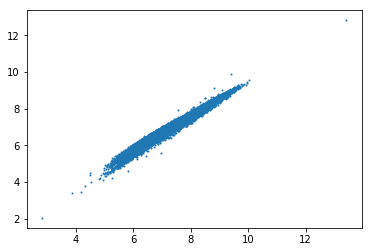

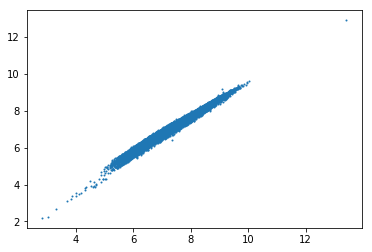

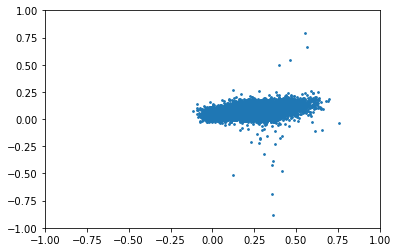

In [116]:
plt.scatter(Jmags,Kmags,s=1.0)
plt.show()
plt.scatter(Jmags,Hmags,s=1.0)
plt.show()
JmH = Jmags-Hmags
HmK = Hmags-Kmags
plt.xlim(-1.,1.)
plt.ylim(-1.,1.)
plt.scatter(JmH,HmK,s=3.0)
plt.show()

Luminosity Class is often but not always given in the Wright et al Spectral Type column. The placement of the luminosity class within the spectral type is not consistent and sometimes there is more than one class (III/IV for example). There are also some that are designated as binaries with 2 spectral types given, generally with a "+" sign between then. The code below tried to deal with this by translative the ascii into a number representation for the class.
V becomes 5.0; III becomes 3.0; IV/V =4.5, etc. If there is no luminosity class given, I assigned 5.1 (assuming that it probably is V but so we can tell the difference from a real V).
Binary stars and stars with funky lumonsity/spectral designations are assigned a negative number.

In [115]:
#  Translate Spectra Type luminosity class into a number from 1 to 5
#     or a negative number if it is a binary or unknown spectral type.
SpType = t1["SpType"]
SpTypeN = [0.0]*len(SpType)
for i in range(0,len(SpType)):
    SpT = SpType[i].decode()
    if(len(SpT) > 2):
        for j in range(0,len(SpT)):
            if(SpT[j] == 'I'):
                SpTypeN[i] = SpTypeN[i] + 1
            if(SpT[j] == 'V'):
                SpTypeN[i] = SpTypeN[i] + 5
            if(SpT[j] == '+'):
                SpTypeN[i] = -20.
                
    else:
        SpTypeN[i] = 5.1
        
    if(SpTypeN[i] == 6):
        SpTypeN[i] = 4.
    if(SpTypeN[i] == 11):
        SpTypeN[i] = 4.5
    if(SpTypeN[i] == 9):
        SpTypeN[i] = 3.5
    if(SpTypeN[i] > 5.2):
        SpTypeN[i] = -30.
print("Finished Luminosity Class Translation")
count = 0
for i in range(0,len(SpType)):
    if(SpTypeN[i] < 0.):
        count = count + 1
good = len(SpType) - count
print("  Number of single Stars: ",good,"  Double stars or Unknown luminosiy class: ",count)


Finished Luminosity Class Translation
  Number of Stars:  28494   Double or Unknown luminosiy class:  321


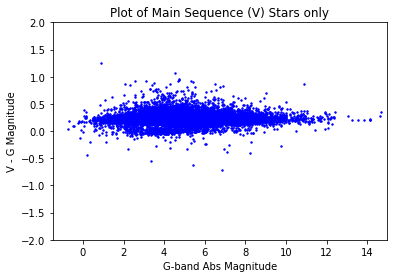

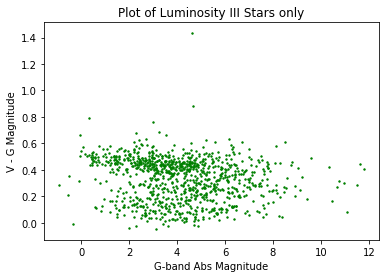

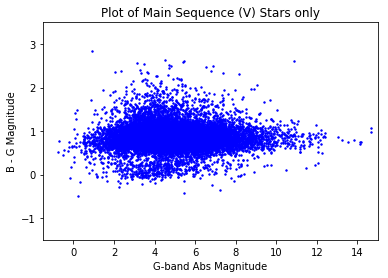

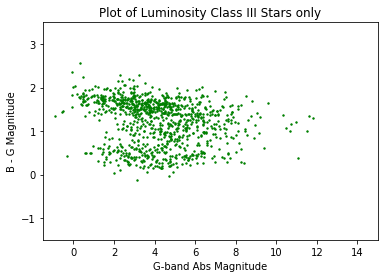

In [124]:
Dist = t1["Dist"]
Vmags = t1['VTmag'] - 5 - 5*np.log10(Dist)
Bmags = t1['BTmag'] - 5 - 5*np.log10(Dist)
Gmags = t1['__Gmag_'] - 5 - 5*np.log10(Dist)
VmG = Vmags - Gmags
BmG = Bmags - Gmags
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 4.9 and SpTypeN[i] < 5.05):
        VmG.mask[i] = False
    else:
        VmG.mask[i] = True
plt.xlim(-1.5,15)
plt.ylim(-2,2)
plt.title("Plot of Main Sequence (V) Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("V - G Magnitude")
plt.scatter(Gmags,VmG,s=2.0,c='b')
plt.show()
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 2.9 and SpTypeN[i] < 3.1):
        VmG.mask[i] = False
    else:
        VmG.mask[i] = True
plt.title("Plot of Luminosity III Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("V - G Magnitude")
plt.scatter(Gmags,VmG,s=2.0,c='g')
plt.show()
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 4.9 and SpTypeN[i] < 5.05):
        BmG.mask[i] = False
    else:
        BmG.mask[i] = True
plt.title("Plot of Main Sequence (V) Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("B - G Magnitude")
plt.xlim(-1.5,15.)
plt.ylim(-1.5,3.5)
plt.scatter(Gmags,BmG,s=2.0,c='b')
plt.show()
for i in range(0,len(VmG)):
    if(SpTypeN[i] > 2.9 and SpTypeN[i] < 3.1):
        BmG.mask[i] = False
    else:
        BmG.mask[i] = True
plt.title("Plot of Luminosity Class III Stars only")
plt.xlabel("G-band Abs Magnitude")
plt.ylabel("B - G Magnitude")
plt.xlim(-1.5,15.)
plt.ylim(-1.5,3.5)
plt.scatter(Gmags,BmG,s=2.0,c='g')
plt.show()


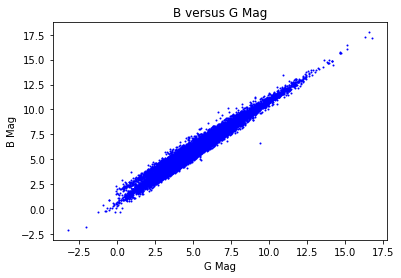

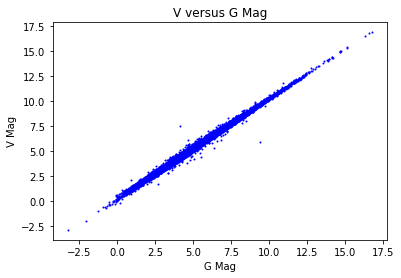

[3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000]


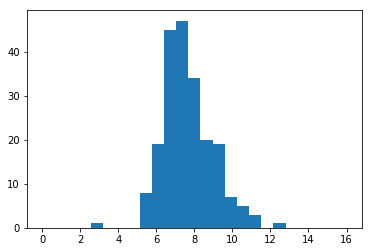

Number of stars in Teff= 3500 - 3999 : 209
     Median value:  7.66688
     Variance:      1.33346


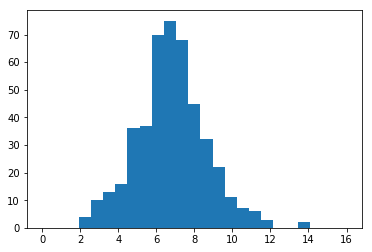

Number of stars in Teff= 4000 - 4499 : 457
     Median value:  6.81424
     Variance:      1.8306


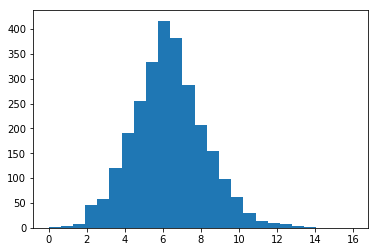

Number of stars in Teff= 4500 - 4999 : 2691
     Median value:  6.33135
     Variance:      1.90336


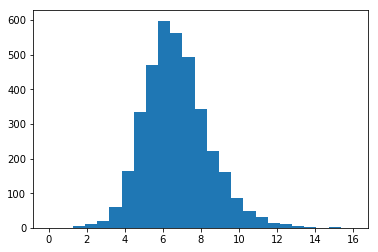

Number of stars in Teff= 5000 - 5499 : 3647
     Median value:  6.72132
     Variance:      1.71226


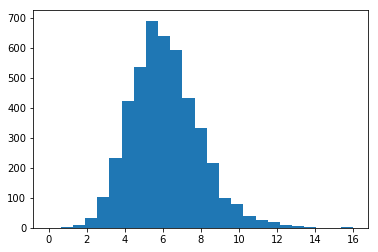

Number of stars in Teff= 5500 - 5999 : 4530
     Median value:  6.13963
     Variance:      1.81446


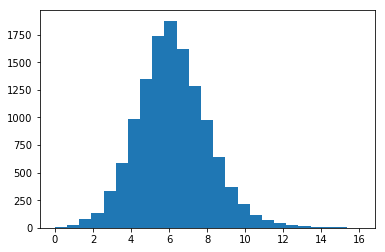

Number of stars in Teff= 6000 - 6499 : 12494
     Median value:  6.19295
     Variance:      1.87245


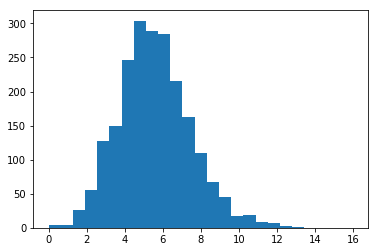

Number of stars in Teff= 6500 - 6999 : 2147
     Median value:  5.57435
     Variance:      1.89846


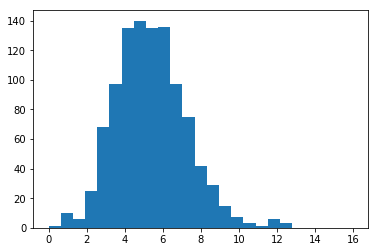

Number of stars in Teff= 7000 - 7499 : 1032
     Median value:  5.3847
     Variance:      1.8567


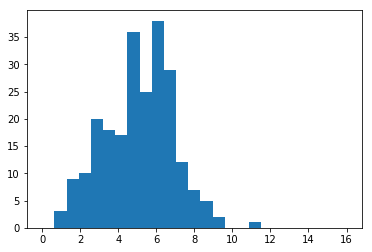

Number of stars in Teff= 7500 - 7999 : 232
     Median value:  5.09957
     Variance:      1.81417


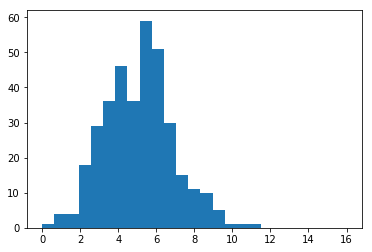

Number of stars in Teff= 8000 - 8499 : 359
     Median value:  5.03884
     Variance:      1.81824


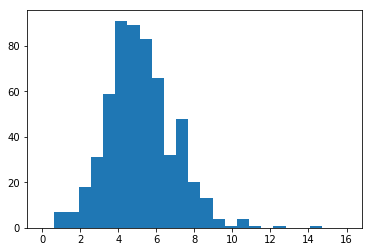

Number of stars in Teff= 8500 - 8999 : 577
     Median value:  5.20385
     Variance:      1.84166


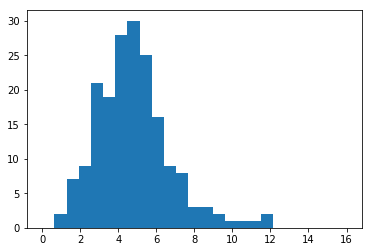

Number of stars in Teff= 9000 - 9499 : 188
     Median value:  4.77534
     Variance:      1.97626


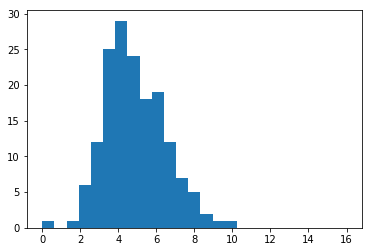

Number of stars in Teff= 9500 - 9999 : 163
     Median value:  4.89932
     Variance:      1.59004


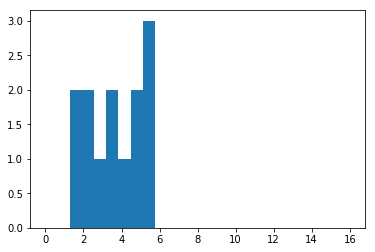

Number of stars in Teff= 10000 - 10499 : 13
     Median value:  3.72831
     Variance:      1.43001


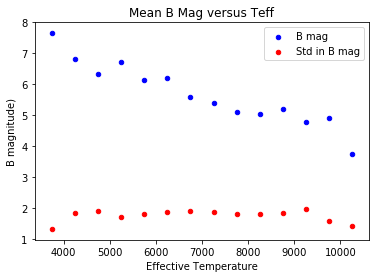

In [21]:
Teff = t1["Teff"]

temps = [3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000]
print(temps)
Tave = []
Bmean = []
Bstd = []

for tlow in temps:
    thi = tlow + 499.
    tmean = (thi+tlow)/2.0
    TeffMask = ma.masked_outside(Teff,tlow,thi)
    BMask = ma.array(Bmags,mask=TeffMask.mask)
    Bplt = ma.compressed(BMask)
    plt.hist(Bplt,bins=25,range=(0,16))
    plt.show()
    Tave.append(tmean)
    Bmean.append(np.mean(Bplt))
    Bstd.append(np.std(Bplt))
    print("Number of stars in Teff= %g - %g :"%(tlow,thi), TeffMask.count())
    print("     Median value: ", np.mean(Bplt))
    print("     Variance:     ",np.std(Bplt))

plt.title("Mean B Mag versus Teff")
plt.xlabel('Effective Temperature')
plt.ylabel('B magnitude)')
pllab1 = plt.scatter(Tave,Bmean,s=20,c='b', label='plt1')
pllab2 = plt.scatter(Tave,Bstd,s=20,c='r', label='plt2')
plt.legend([pllab1,pllab2],['B mag','Std in B mag'])
plt.show()

In [48]:
eGflux = t1["e__FG_"]
Gflux = t1["__FG_"]
Gmags = t1["__Gmag_"]
for i in range(0,len(Gflux)):
    SNR = Gflux[i]/eGflux[i]
    if(SNR < 20):
        print(Gflux[i],eGflux[i],SNR, Gmags[i])
print("Finished testing G-band SNR")

4715350.45069 297926.3987 15.8272327369 8.841
470609.26764 38319.77203 12.2811082298 11.343
9454890.22577 871081.47488 10.8541973379 8.086
620078.72445 40360.92696 15.3633420031 11.044
16644155.3597 1417120.64402 11.7450517921 7.472
11712494.7108 874715.62735 13.3900599744 7.853
77333.06189 12615.8944 6.12981207975 13.304
4230130.34385 279291.46995 15.1459346202 8.959
4411172.55434 230246.49579 19.1584785654 8.913
13770167.194 876170.21459 15.7163151231 7.677
52812834.1968 3399307.1187 15.5363526603 6.218
16753852.9399 1791108.42674 9.35390213666 7.464
19073235.7548 958879.2069 19.8911767171 7.324
5539576.347 296924.21656 18.6565326708 8.666
Finished testing G-band SNR


In [7]:
Teff = t2["Teff"]
plt.title("Histogram of Teff")
plt.xlabel('Teff bins')
plt.ylabel('Number of stars in bin')
plt.hist(Teff,bins=30,color='b')
plt.show()

plt.title("Histogram of Teff")
plt.xlabel('Teff bins')
plt.ylabel('Number of stars in bin')
plt.hist(Teff,bins=45,range=(2000,12000),color='b')
plt.show()

print("Results of number of stars in low Teff bins for TGAS x Wright et al Catalog")
TeffMask = ma.masked_outside(Teff,2000,2500)
print("   Number of stars between 2000 and 2500: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,2501,3000)
print("   Number of stars between 2501 and 3000: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,3001,3500)
print("   Number of stars between 3001 and 3500: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,3501,4000)
print("   Number of stars between 3500 and 4000: ", TeffMask.count())
TeffMask = ma.masked_outside(Teff,4001,4500)
print("   Number of stars between 4001 and 4500: ", TeffMask.count())

NameError: name 't2' is not defined

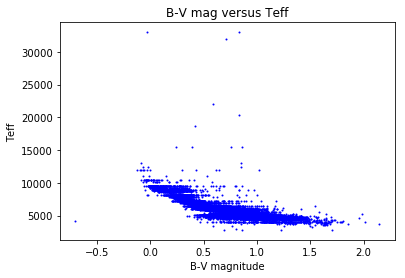

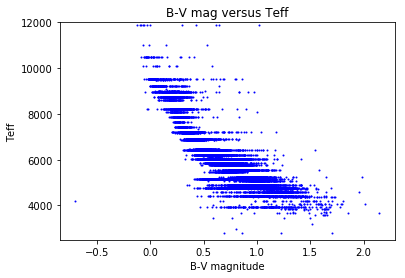

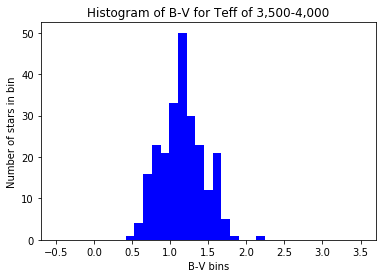

Number of stars in Teff=3,500-4,000: 241
     Median value:  1.16004
     Variance:      0.285972


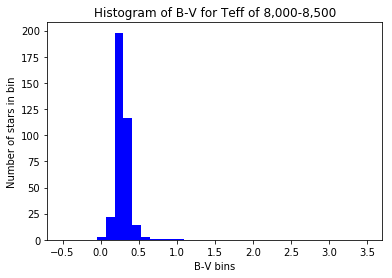

Number of stars in Teff=8,000-8,500: 360
     Median value:  0.283161
     Variance:      0.101145
[2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000, 10500, 11000, 11500, 12000]
Number of stars in Teff= 2500 - 2999 : 5
     Median value:  1.0554
     Variance:      0.368924
Number of stars in Teff= 3000 - 3499 : 5
     Median value:  1.1244
     Variance:      0.380902
Number of stars in Teff= 3500 - 3999 : 234
     Median value:  1.15772
     Variance:      0.282588
Number of stars in Teff= 4000 - 4499 : 501
     Median value:  1.14551
     Variance:      0.266066
Number of stars in Teff= 4500 - 4999 : 2880
     Median value:  0.997642
     Variance:      0.190006
Number of stars in Teff= 5000 - 5499 : 3780
     Median value:  0.810099
     Variance:      0.147398
Number of stars in Teff= 5500 - 5999 : 4931
     Median value:  0.74942
     Variance:      0.0964396
Number of stars in Teff= 6000 - 6499 : 12708
     Median value:  0.593711
 

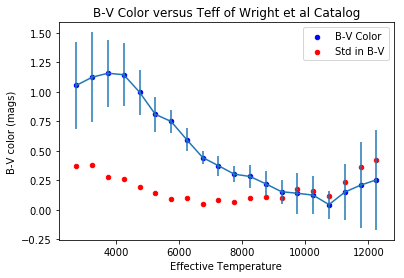

In [7]:
Teff = t2["Teff"]
Bmags = t2["BTmag"]
Vmags = t2["VTmag"]
BmV = Bmags - Vmags
plt.title("B-V mag versus Teff")
plt.xlabel('B-V magnitude')
plt.ylabel('Teff')
plt.scatter(BmV,Teff,color='b',s=1.0)
plt.show()

plt.title("B-V mag versus Teff")
plt.xlabel('B-V magnitude')
plt.ylabel('Teff')
plt.ylim(2500,12000)
plt.scatter(BmV,Teff,color='b',s=1.0)
plt.show()

TeffMask = ma.masked_outside(Teff,3500,4000)
BmVMask = ma.array(BmV,mask=TeffMask.mask)
BmVplt = BmVMask.compressed()
plt.title("Histogram of B-V for Teff of 3,500-4,000")
plt.xlabel('B-V bins')
plt.ylabel('Number of stars in bin')
plt.hist(BmVplt,bins=35,range=(-0.5,3.5),color='b')
plt.show()
print("Number of stars in Teff=3,500-4,000:", TeffMask.count())
print("     Median value: ", np.mean(BmVplt))
print("     Variance:     ",np.std(BmVplt))

TeffMask = ma.masked_outside(Teff,8000,8500)
BmVMask = ma.array(BmV,mask=TeffMask.mask)
BmVplt = BmVMask.compressed()
plt.title("Histogram of B-V for Teff of 8,000-8,500")
plt.xlabel('B-V bins')
plt.ylabel('Number of stars in bin')
plt.hist(BmVplt,bins=35,range=(-0.5,3.5),color='b')
plt.show()
print("Number of stars in Teff=8,000-8,500:", TeffMask.count())
print("     Median value: ", np.mean(BmVplt))
print("     Variance:     ",np.std(BmVplt))

temps = [2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500,8000,8500,9000,9500,10000,10500,11000,11500,12000]
print(temps)
Tave = []
BmVave = []
BmVstd = []
for tlow in temps:
    thi = tlow + 499.
    tmean = (thi+tlow)/2.0
    TeffMask = ma.masked_outside(Teff,tlow,thi)
    BmVMask = ma.array(BmV,mask=TeffMask.mask)
    BmVplt = BmVMask.compressed()
    Tave.append(tmean)
    BmVave.append(np.mean(BmVplt))
    BmVstd.append(np.std(BmVplt))
    print("Number of stars in Teff= %g - %g :"%(tlow,thi), TeffMask.count())
    print("     Median value: ", np.mean(BmVplt))
    print("     Variance:     ",np.std(BmVplt))
print(Tave)
print(BmVave)

plt.title("B-V Color versus Teff of Wright et al Catalog")
plt.xlabel('Effective Temperature')
plt.ylabel('B-V color (mags)')
pllab1 = plt.scatter(Tave,BmVave,s=20,c='b', label='plt1')
pllab2 = plt.scatter(Tave,BmVstd,s=20,c='r', label='plt2')
plt.legend([pllab1,pllab2],['B-V Color','Std in B-V'])
plt.errorbar(Tave,BmVave,yerr=BmVstd)
plt.show()


140519581833816
6440
140519632631288
6440
--
6440
6440
12880
6440


/astromake/opt/python/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


In [59]:
len(b)

28815